<a href="https://colab.research.google.com/github/sheikhi-a/Big-data-with-Python/blob/main/spark_preprocessing_missing_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# preprocessing and exloring data using Spark


By Ayyub Sheikhi, SBUK  (sheikhy.a@uk.ac.ir)

In [ ]:

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq



The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123633 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u432-ga~us1-0ubuntu2~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u432-ga~us1-0ub

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"



In [ ]:

from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()


print(spark)
spark


In [ ]:
spark

In [ ]:
#SparkContext is created by default with the variable name sc
sc = spark.sparkContext
sc

<SparkContext master=local[1] appName=SparkByExamples.com>

In [ ]:
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

#print (pyspark.__version__)

In [ ]:
#running spark default settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

%matplotlib inline

In [ ]:
# Data Frame spark profiling
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

Copy the mall customers data set to the content
[link text](https://github.com/elsyifa/Clustering-Pyspark/blob/master/Mall_Customers.csv)

In [ ]:

#Initializing File Type
file_type = 'text'
path=r'Mall_Customers.csv'
delimeter=','
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
        .option("delimeter",delimeter)\
        .option("inferSchema", "true") \
        .csv(path)
    else:
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df
df = load_data(file_type)
help(load_data)

load_data(file_type)


Help on function load_data in module __main__:

load_data(file_type)
    input type of file "text" or "parquet" and Return pyspark dataframe



DataFrame[CustomerID: int, Genre: string, Age: int, Annual Income (k$): int, Spending Score (1-100): int]

,0
CustomerID,0
Genre,5
Age,0
Annual Income (k$),4
Spending Score (1-100),5


# Preprocessing

1-name of variables

In [ ]:
df.printSchema()

df=df.withColumnRenamed('CustomerID','Id')
df=df.withColumnRenamed('Annual Income (k$)','AnnIncome')
df=df.withColumnRenamed('Spending Score (1-100)','SpendScore')
df=df.withColumnRenamed('Genre','Gender')

len(df.columns), df.columns


(5, ['Id', 'Gender', 'Age', 'AnnIncome', 'SpendScore'])

In [ ]:



df.dtypes

num_cols=['Age', 'AnnIncome', 'SpendScore']
df.select(num_cols).describe().show()

df.select('Age').describe().show()

mean_age=df.select('Age').describe().collect()[1],[1]
mean_age



+-------+-----------------+-----------------+------------------+
|summary|              Age|        AnnIncome|        SpendScore|
+-------+-----------------+-----------------+------------------+
|  count|              200|              196|               195|
|   mean|            38.85|60.73979591836735| 50.43589743589744|
| stddev|13.96900733155888|26.33197623168131|25.565758018924654|
|    min|               18|               15|                 1|
|    max|               70|              137|                99|
+-------+-----------------+-----------------+------------------+

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|              200|
|   mean|            38.85|
| stddev|13.96900733155888|
|    min|               18|
|    max|               70|
+-------+-----------------+



(Row(summary='mean', Age='38.85'), [1])


3- Missing values detection

In [ ]:
df_pd=df.toPandas()
df_pd.head(15)

mis_val = df_pd.isnull().sum()
#df_pd['Gender'] = df_pd['Gender'].replace(["", "NaN", "n/a", "null", " "], np.nan)
mis_val = df_pd.isnull().sum()

mis_valA = df_pd.AnnIncome.isnull().sum()
mis_valAge = df_pd.Age.isnull().sum()


df_Nomiss=df.na.drop()
df_Nomiss.count()
df_n_pd=df_Nomiss.toPandas()
df_n_pd.isnull().sum()


df_Nomiss.groupBy('Gender').count()
df_Nomiss.groupBy('Gender').count().show()


df_Nomiss.groupBy('Gender').count().sort(col("count").desc()).show()
df_Nomiss.groupBy('Gender').count().sort(col("count").asc()).show()


,0
Id,0
Gender,5
Age,0
AnnIncome,4
SpendScore,5


In [ ]:

mode=df_Nomiss.groupBy('Gender').count().sort(col("count").desc()).collect()[0][0]
mode1=df_Nomiss.groupBy('Gender').count().sort(col("count").asc()).collect()[1][0]

df.show()

df = df.na.fill({'Gender':mode})
df.show()

df.describe().show()
df.select(mean('AnnIncome')).show()
meanvalue = df.select(mean('AnnIncome')).collect()[0][0]
df = df.na.fill({'AnnIncome':meanvalue})

df_pd2=df_Nomiss.toPandas()
plt.boxplot(df_pd2.AnnIncome)
plt.boxplot(df_pd2.SpendScore)


meanvalue = df.select(mean('SpendScore')).collect()[0][0]
df = df.na.fill({'SpendScore':meanvalue})


df_pd1=df.toPandas()
plt.boxplot(df_pd.AnnIncome)

medvalue = df.select(median('AnnIncome')).collect()[0][0]
df = df.na.fill({'AnnIncome':medvalue})


meanvalue = df.select(mean('SpendScore')).collect()[0][0]
df = df.na.fill({'SpendScore':meanvalue})

df_pd3=df.toPandas()
df_pd3.isnull().sum()


+---+------+---+------------------+------------------+
| Id|Gender|Age|         AnnIncome|        SpendScore|
+---+------+---+------------------+------------------+
|  1|  Male| 19|              15.0|              39.0|
|  2|  Male| 21|              15.0|              81.0|
|  3|Female| 20|              16.0|               6.0|
|  4|Female| 23|              16.0|              77.0|
|  5|Female| 31|              17.0|              40.0|
|  6|Female| 22|              17.0|              76.0|
|  7|Female| 35|              18.0|               6.0|
|  8|Female| 23|61.554707084881784|              94.0|
|  9|  Male| 64|              19.0| 35.87735159189907|
| 10|Female| 30|              19.0|              72.0|
| 11|  Male| 67|              19.0|              14.0|
| 12|Female| 35|              19.0|              99.0|
| 13|Female| 58|              20.0| 39.23510183721751|
| 14|Female| 24|              20.0|              77.0|
| 15|  Male| 37|              20.0|              13.0|
| 16|  Mal

# Implement missing values using the regression equation

In [ ]:
from sklearn.linear_model import LinearRegression

nomisdata = df_pd[df_pd['AnnIncome' ].notna()]
nomisdata.isnull().sum()

x = nomisdata[['Age']] #PREDICTOR
y = nomisdata['AnnIncome'] # DEPENDENT

reg_model = LinearRegression()
reg_model.fit(x, y)

coefficient = reg_model.coef_
intercept = reg_model.intercept_


print("AnnIncome =", intercept,  coefficient[0],"Age")


missing_data = df_pd[df_pd['AnnIncome'].isna()]
missing_data
missing_data.head(6)
X_missing = missing_data[['Age']]
predicted_values = reg_model.predict(X_missing)

df_pd.loc[df_pd['AnnIncome'].isna(), 'AnnIncome'] = predicted_values

df_pd.isna().sum()
df= spark.createDataFrame(df_pd)


df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns]
   ).show()


In [ ]:
nomisdata1 = df_pd[df_pd['SpendScore' ].notna()]
nomisdata1.isnull().sum()

x = nomisdata1[['Age','AnnIncome' ]]# predictors
y = nomisdata1['SpendScore']#dependent

reg_model = LinearRegression()
reg_model.fit(x, y)

coefficient = reg_model.coef_
intercept = reg_model.intercept_


print("Spendscore =", intercept, coefficient[0],"Age", "+", coefficient[1],"Annsalary")


missing_data1 = df_pd[df_pd['SpendScore'].isna()]
X_missing1 = missing_data1[['Age','AnnIncome' ]]
predicted_values1 = reg_model.predict(X_missing1)

df_pd.loc[df_pd['SpendScore'].isna(), 'SpendScore'] = predicted_values1

df_pd.isna().sum()

,0
Id,0
Gender,5
Age,0
AnnIncome,0
SpendScore,0


Graphical representation for another preprocessing

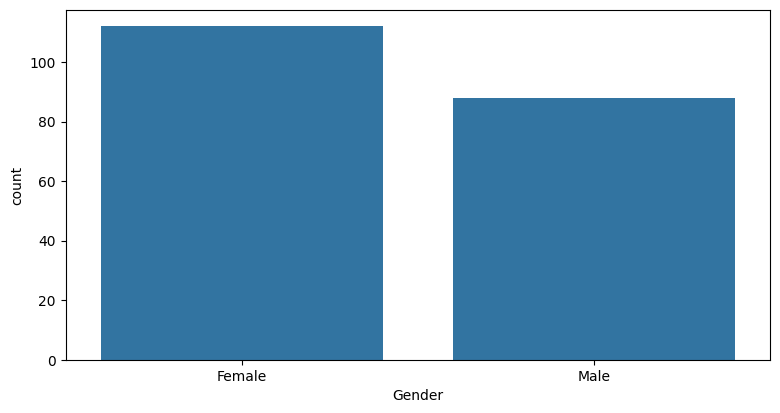

In [ ]:
import seaborn as sns

df_pd2=df.toPandas()

plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='Gender', data=df_pd2, order=df_pd['Gender'].value_counts().index)
plt.show()

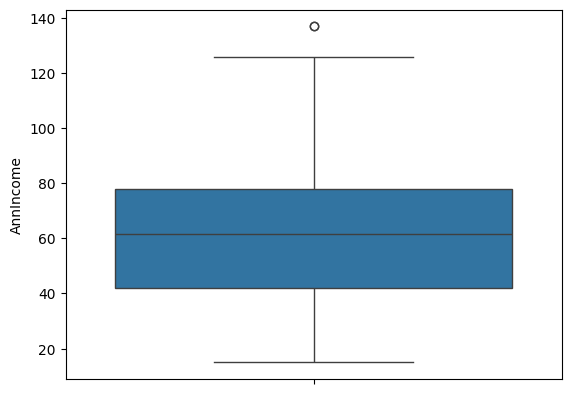

In [ ]:
#Checking outliers

sns.boxplot(y="Age",data=df_pd2)
plt.show()


sns.boxplot(y="AnnIncome",data=df_pd2)
plt.show()



# Handle of outlier


Q1 = the value that cut off 25% of the first data when it is sorted in ascending order.

Q2 =  median

Q3 = the value that cut off 75% of the first data when it is sorted in ascending order.

IQR or interquartile range is range between Q1 and Q3. IQR = Q3 - Q1.

Upper side = Q3 + 1.5 * IQR

Lower side = Q1 - 1.5 * IQR

Outliers  are equivalent  to the observation that our grather thab the upper side or less than the lower side

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9d2ffe6350>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9d2ffe4670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9d2ffe6f20>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9d2e7cf820>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9d2e7cffd0>],
 'means': []}

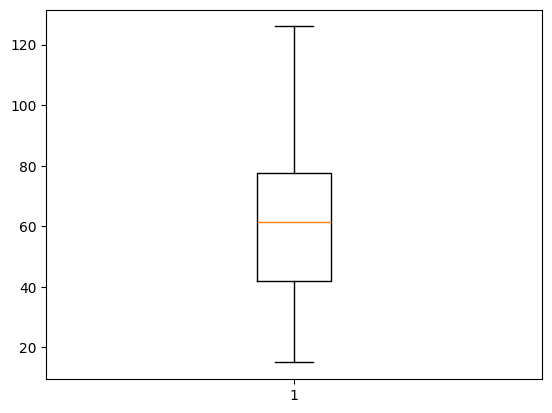

In [ ]:
from pyspark.sql.functions import col, expr, percentile_approx


percentiles = df.select(
    percentile_approx("AnnIncome", 0.25).alias("Q1"),
    percentile_approx("AnnIncome", 0.75).alias("Q3")
).collect()

Q1 = percentiles[0]["Q1"]
Q3 = percentiles[0]["Q3"]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df.filter((col("AnnIncome") < lower_bound) | (col("AnnIncome") > upper_bound))

outliers.show()
df_no_outlier= df.filter((col("AnnIncome") >lower_bound) & (col("AnnIncome") < upper_bound))
df_no_outlier.count()




df_no_outlier.describe().show()
df_no_out_pd=df_no_outlier.toPandas()
plt.boxplot(df_no_out_pd.AnnIncome)


In [ ]:
sc.stop()